# CS 109A/STAT 121A/AC 209A/CSCI E-109A: Homework 3
# Multiple Linear Regression, Subset Selection, Cross Validation

**Harvard University**<br/>
**Fall 2017**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, Rahul Dave, Margo Levine

---

### INSTRUCTIONS

- To submit your assignment follow the instructions given in canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- Do not include your name(s) in the notebook if you are submitting as a group. 
- If you submit individually and you have worked with someone, please include the name of your [one] partner below. 

---

Your partner's name (if you submit separately): Everett Sussman, Jan Geffert

Enrollment Status (109A, 121A, 209A, or E109A): 109A

Import libraries:

In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
from scipy import stats
import statsmodels.api as sm
from statsmodels.api import OLS
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
%matplotlib inline
sns.set_context("poster")

/Applications/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Forecasting Bike Sharing Usage

In this homework, we will focus on multiple linear regression and will explore techniques for subset selection. The specific task is to build a regression model for a bike share system that can predict the total number of bike rentals in a given day, based on attributes about the day. Such a demand forecasting model would be useful in planning the number of bikes that need to be available in the system on any given day, and also in monitoring traffic in the city. The data for this problem was collected from the Capital Bikeshare program in Washington D.C. over two years.   

The data set is provided in the files `Bikeshare_train.csv` and `Bikeshare_test.csv`, as separate training and test sets. Each row in these files contains 10 attributes describing a day and its weather:
- season (1 = spring, 2 = summer, 3 = fall, 4 = winter)
- month (1 through 12, with 1 denoting Jan)
- holiday (1 = the day is a holiday, 0 = otherwise)
- day_of_week (0 through 6, with 0 denoting Sunday)
- workingday (1 = the day is neither a holiday or weekend, 0 = otherwise)
- weather 
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
- temp (temperature in Celsius)
- atemp (apparent temperature, or relative outdoor temperature, in Celsius)
- humidity (relative humidity)
- windspeed (wind speed)

and the last column 'count' contains the response variable, i.e. total number of bike rentals on the day.


## Part (a): Data Exploration & Preprocessing

As a first step, identify important characteristics of the data using suitable visualizations when necessary. Some of the questions you may ask include (but are not limited to):

- How does the number of bike rentals vary between weekdays and weekends? 
- How about bike rentals on holidays?
- What effect does the season have on the bike rentals on a given day?
- Is the number of bike rentals lower than average when there is rain or snow?
- How does temperature effect bike rentals?
- Do any of the numeric attributes have a clear non-linear dependence with number of the bike rentals?



In [2]:
# Create Dataframes
trainDf = pd.read_csv("Bikeshare_train.csv")
testDf = pd.read_csv("Bikeshare_test.csv")

In [3]:
trainDf.head()

,Unnamed: 0,season,month,holiday,day_of_week,workingday,weather,temp,atemp,humidity,windspeed,count
0,0,2,5,0,2,1,2,24,26,76.5833,0.118167,6073
1,1,4,12,0,2,1,1,15,19,73.3750,0.174129,6606
2,2,2,6,0,4,1,1,26,28,56.9583,0.253733,7363
3,3,4,12,0,0,0,1,0,4,58.6250,0.169779,2431
4,4,3,9,0,3,1,3,23,23,91.7083,0.097021,1996


In [4]:
# trainDf summary statistics
trainDf.shape

(331, 12)

In [5]:
# testDf summary statistics
testDf.shape

(400, 12)

### Importing the Data
We noticed that our data set appears to be very clean - all columns are filled with values, each data point is atomic, etc.  We also noticed that our testing data table contains more data points than our training data table.  

### Number of Rentals per Day
The first question our group wanted to answer was what the overall distribution of our $y$ variable, the number of bikes rented per day, looked like.  Thus, we created the below histogram.

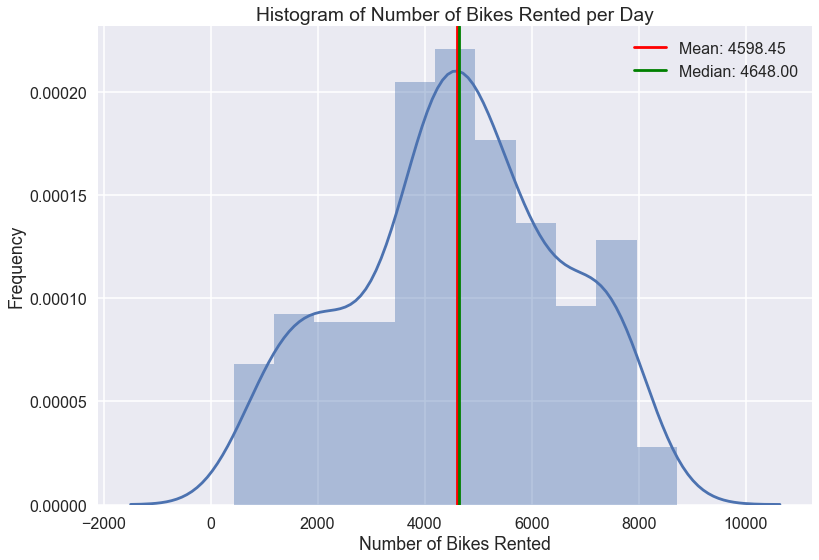

In [6]:
# General histogram of count data
meanBikesRented = np.mean(trainDf["count"])
medianBikesRented = np.median(trainDf["count"])


fig, ax = plt.subplots(1)
ax = sns.distplot(trainDf["count"])
ax.set_title("Histogram of Number of Bikes Rented per Day")
ax.set_xlabel("Number of Bikes Rented")
ax.set_ylabel("Frequency")

ax.axvline(x = meanBikesRented, color="r", label = "Mean: {0:.2f}".format(meanBikesRented))
ax.axvline(x = medianBikesRented, color="g", label = "Median: {0:.2f}".format(medianBikesRented))
ax.legend()

The histogram above shows a fairly symmetrical distribution of values, as the mean and median are very similar. On an average day, 4648 bikes are rented.  We also note that there tend to be small *sub-peaks* in our histogram at around 1500 bikes rented and 7500 bikes rented.  There are no nonsensical values, such as negative bikes rented in a day.  

### Weekdays vs. Weekends
Next, we investigated whether bikes, on average, were more likely to be used during the weekend versus weekdays.  

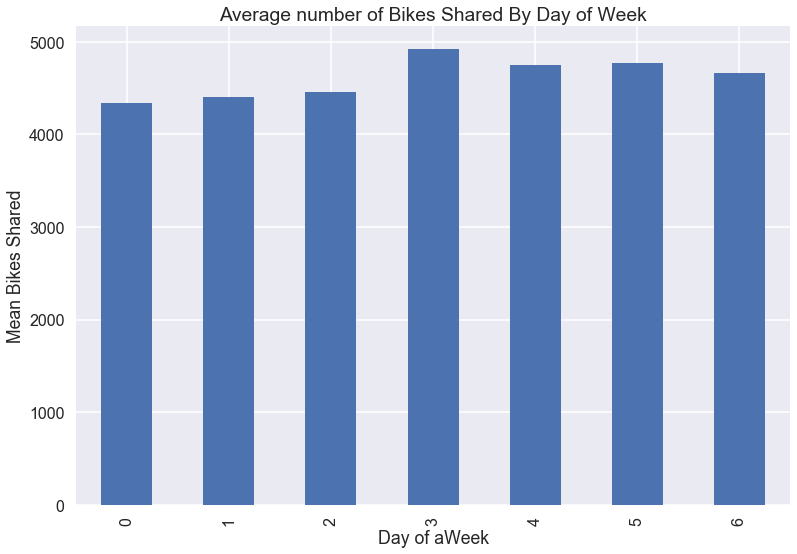

In [7]:
dayGroup = trainDf.groupby("day_of_week", as_index=True)
ax = dayGroup["count"].mean().plot(kind="bar", title="Average number of Bikes Shared By Day of Week")
ax.set_xlabel("Day of aWeek")
ax.set_ylabel("Mean Bikes Shared")

In [8]:
# Find mean for weekdays, mean for weekends
weekMean = np.mean(dayGroup["count"].mean()[1:-2])
weekendMean = np.mean([dayGroup["count"].mean()[0],dayGroup["count"].mean()[6]])
print("Mean bikes rented during the week: {}, Mean bikes rented during the weekend: {}".format(weekMean, weekendMean))

Mean bikes rented during the week: 4634.760765349032, Mean bikes rented during the weekend: 4503.6314465408805


We find that, on average, slightly more bikes are rented during the week (4635 > 4504). This suggests the usage of rental bikes by commuters, as opposed to leisure.  

### Holidays
Next, we investigated whether the indicator of a day being a holiday impacted overal bike rentals.

([<matplotlib.axis.XTick at 0x115e4cac8>,
 <a list of 2 Text xticklabel objects>)

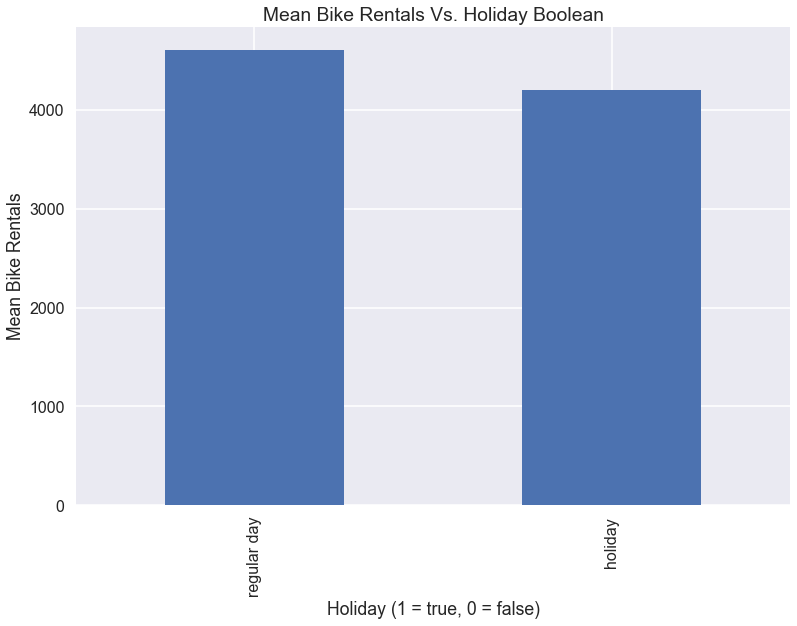

In [9]:
# Holiday Analysis
holidayGroup = trainDf.groupby("holiday")
ax = holidayGroup["count"].mean().plot(kind="bar", title="Mean Bike Rentals Vs. Holiday Boolean")
ax.set_xlabel("Holiday (1 = true, 0 = false)")
ax.set_ylabel("Mean Bike Rentals")
plt.xticks([0,1], ["regular day", "holiday"])

In [10]:
hMeans = holidayGroup["count"].mean()
print("Mean Bike Rentals during a non-Holiday: {}, Mean Bike Rentals during a Holiday: {}.".format(hMeans[0], hMeans[1]))

Mean Bike Rentals during a non-Holiday: 4612.171875, Mean Bike Rentals during a Holiday: 4199.181818181818.


We find that, on average, more bikes are rented during a non-holiday. This further hints at the commuter-hypothesis.

### Seasonal effects
Now, our group wanted to determine whether the season impacted the relative popularity of bike rentals throughout the week.  For example, in the summer, we would imagine that more people would rent a bike during the weekend than in the winter time, when the only people biking would be those that relied on bikes to commute.  

To visualize this, in the below graph, we plotted 4 trend lines throughout the week detailing the normalized average bike rentals per day.  To normalize each trend line, we divided the daily average by the seasonal average.  

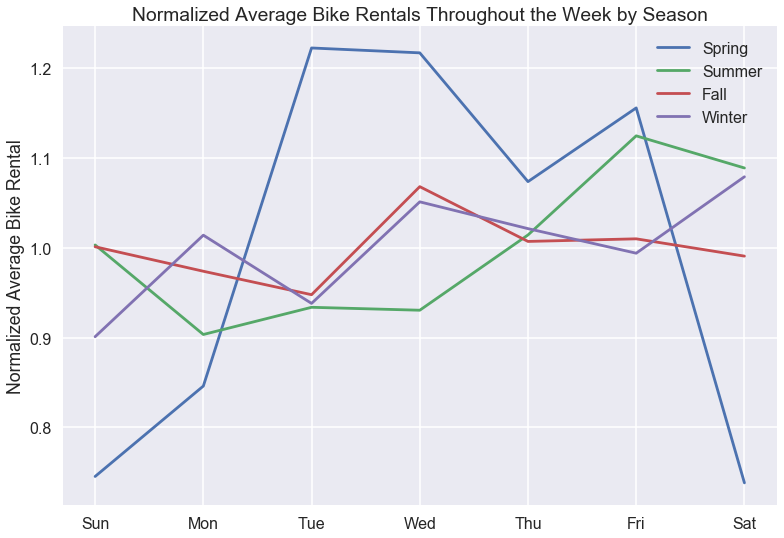

In [11]:
seasonDayGroup = trainDf.groupby(["season", "day_of_week"])["count"].mean()
fig, ax = plt.subplots(1)
seasonNames = ["Spring", "Summer", "Fall", "Winter"]
for season in range(1,5):
    mean = np.mean(seasonDayGroup[season])
    normalizedRentals = list(map(lambda x: x / mean, seasonDayGroup[season]))
    ax.plot(normalizedRentals, label=seasonNames[season-1])
    ax.legend()
    ax.set_title("Normalized Average Bike Rentals Throughout the Week by Season")
    plt.xticks(range(7), ["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"])
    ax.set_ylabel("Normalized Average Bike Rental")

After normalizing the rentals of each season by dividing by the seasonal average, we find that there is considerably more variation in the spring time than in the other seasons.  Also, in the spring, weekends are surprisingly unpopular in terms of average bike rentals compared to the weekdays.  However, in contrast, in the summer, Fridays are very popular.  Lastly, in the winter time, Saturday is the most popular day to rent a bike, relative to other days in the week.  This was incredibly surprising, and throws a wrench into our initial hypothesis that most bike rentals were for commuting purposes only.  

### Weather Effects
Now, our group investigated whether the severity of weather impacted bike rentals in any given day.  

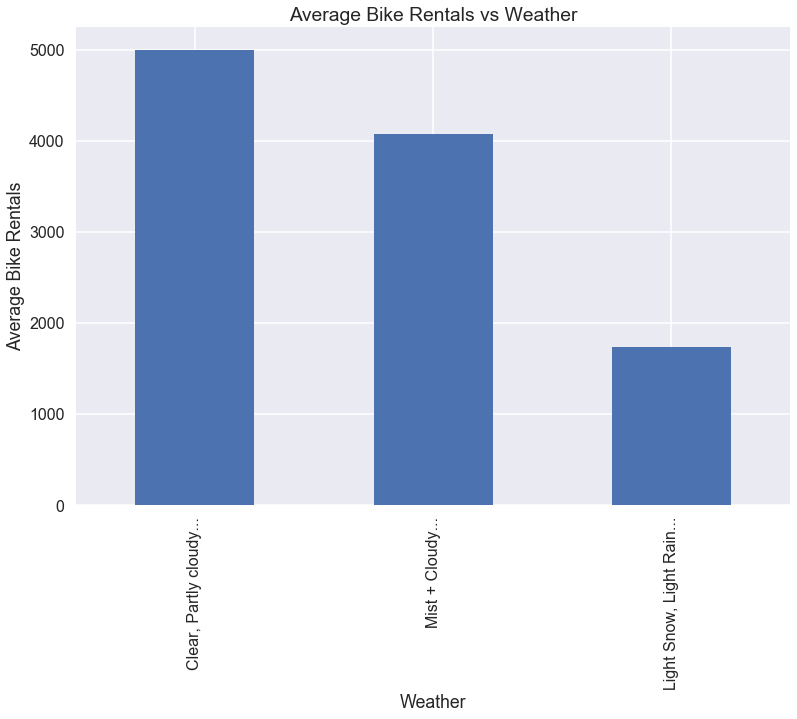

In [12]:
weatherGroup = trainDf.groupby("weather")["count"].mean()

ax = weatherGroup.plot(kind="bar", title="Average Bike Rentals vs Weather")
plt.xticks(range(0,3), ["Clear, Partly cloudy...", "Mist + Cloudy...", "Light Snow, Light Rain..."])
ax.set_xlabel("Weather")
ax.set_ylabel("Average Bike Rentals")

In the above graph, we see that, as expected, when the weather worsens, fewer people rent bikes.

In [13]:
# Print out means:
weatherDiff = []

for weather in range(1,4):
    weatherMean = np.mean(weatherGroup[weather])
    weatherDiff.append(weatherMean - meanBikesRented)
    if weatherDiff[-1] > 0:
        print("Weather {} has a mean of: {}, which is {} more than the annual mean.".format(weather, weatherMean, np.abs(weatherDiff[-1])))
    else:
        print("Weather {} has a mean of: {}, which is {} less than the annual mean.".format(weather, weatherMean, np.abs(weatherDiff[-1])))

Weather 1 has a mean of: 5001.476415094339, which is 403.02928518497356 more than the annual mean.
Weather 2 has a mean of: 4077.1651376146788, which is 521.2819922946869 less than the annual mean.
Weather 3 has a mean of: 1736.2, which is 2862.247129909366 less than the annual mean.


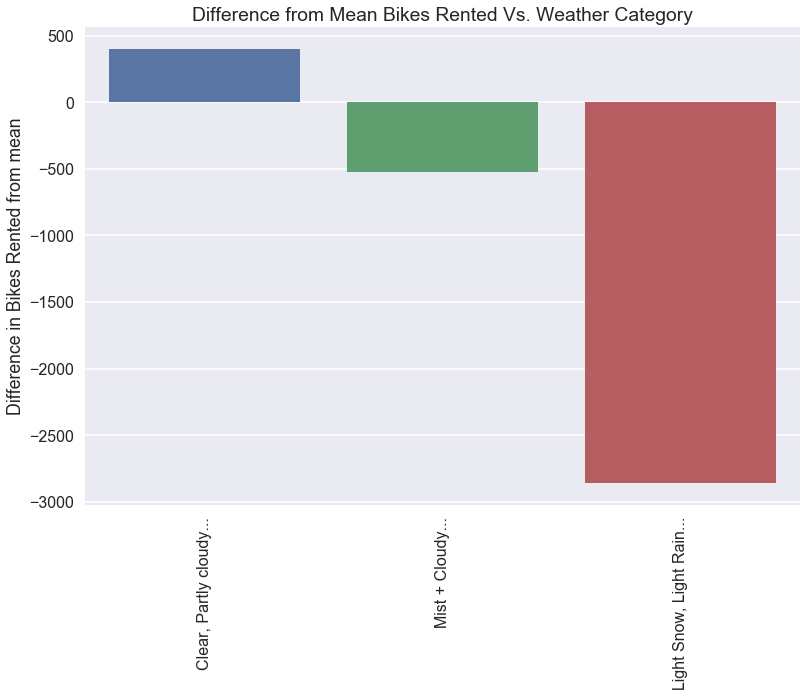

In [14]:
fig, ax = plt.subplots(1)
ax = sns.barplot(list(range(3)), weatherDiff)
ax.set_title("Difference from Mean Bikes Rented Vs. Weather Category")
plt.xticks(range(0,3), ["Clear, Partly cloudy...", "Mist + Cloudy...", "Light Snow, Light Rain..."], rotation=90)
ax.set_ylabel("Difference in Bikes Rented from mean")

The above visualization takes this notion one step further, by revealing how far fewer bikes are rented in bad weather than the total average of bikes rented.

### Temperature
Here, our group investigated the impact of temperature on bike rentals.

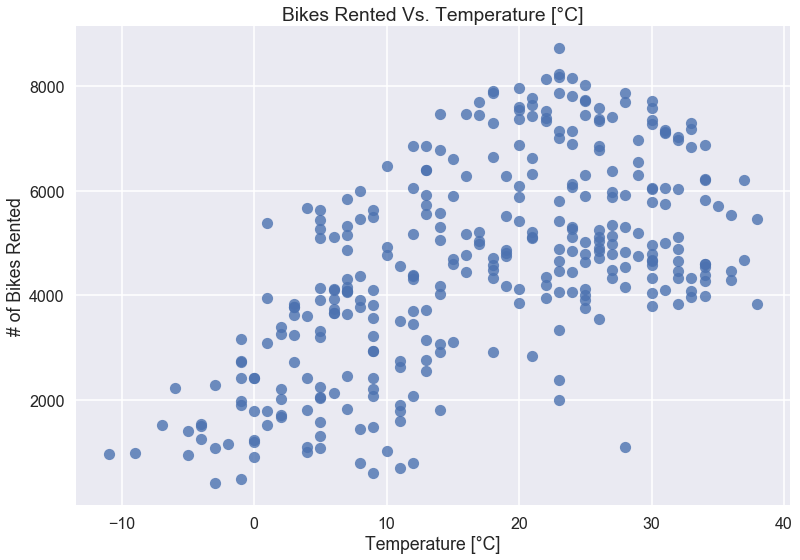

In [15]:
fig, ax = plt.subplots(1)
ax = sns.regplot(trainDf["temp"], trainDf["count"], fit_reg=False)
ax.set_title("Bikes Rented Vs. Temperature [°C]")
ax.set_xlabel("Temperature [°C]")
ax.set_ylabel("# of Bikes Rented")

There seems to be a generally positive correlation of *number of bikes rented* and *temperature, which makes sense, given our prior findings. At temperatures of 25 degrees or more, however, higher temperatures are associated with a reduction in ridership, presumably because riding becomes more cumbersome (and sweaty).

### Checking for Non-linear Dependencies

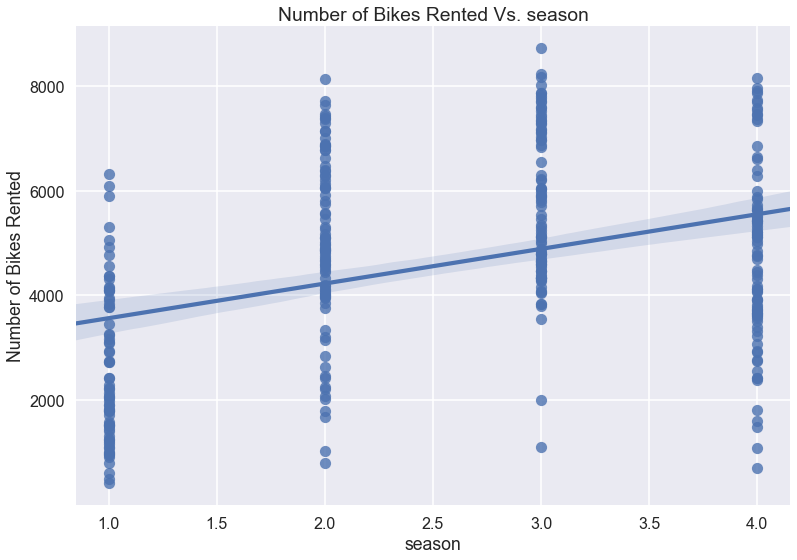

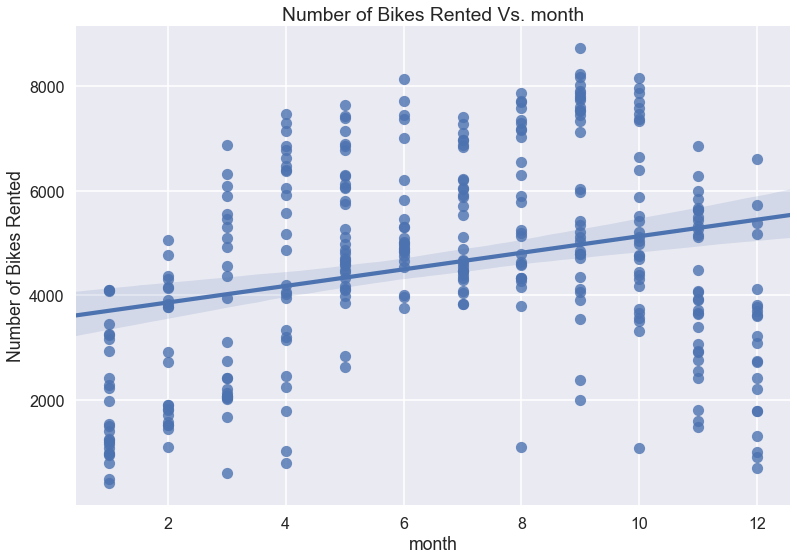

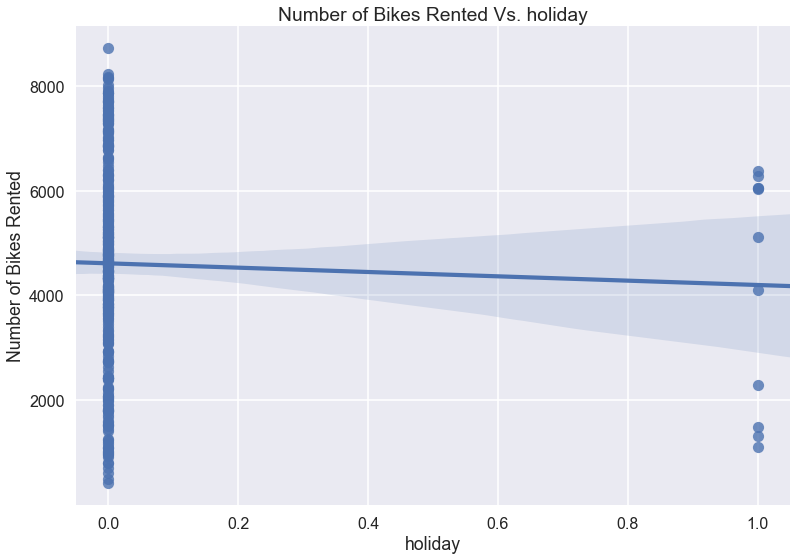

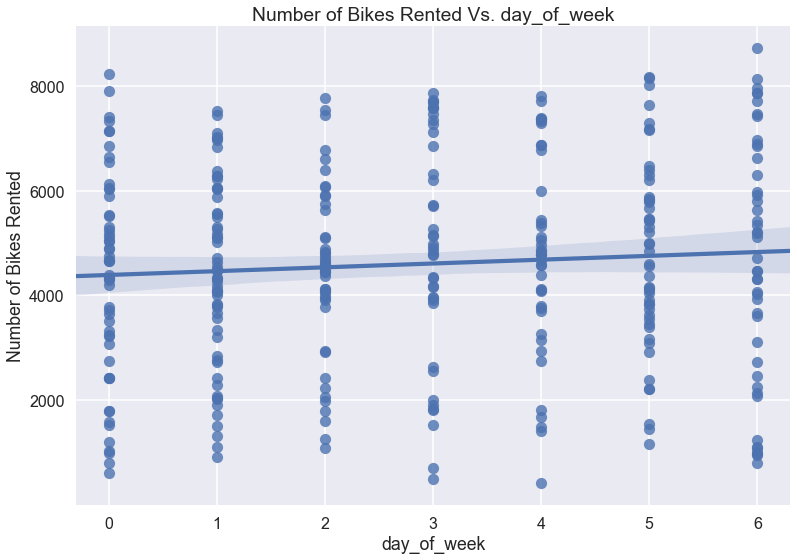

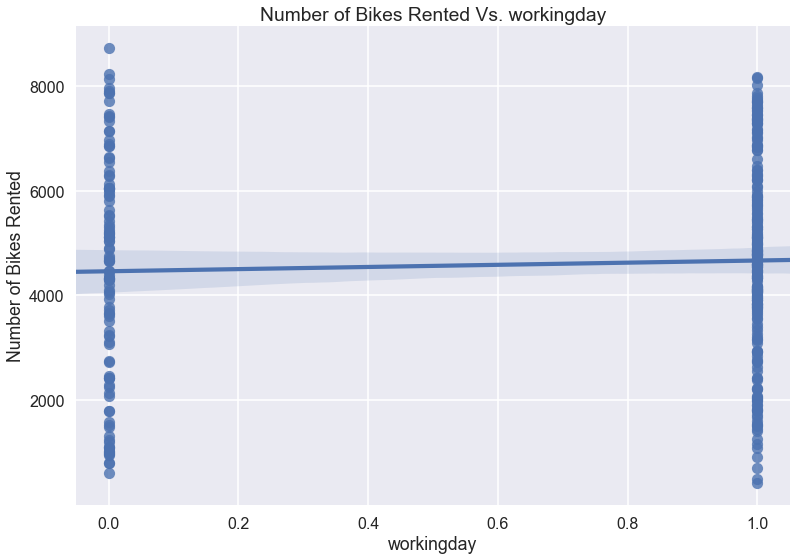

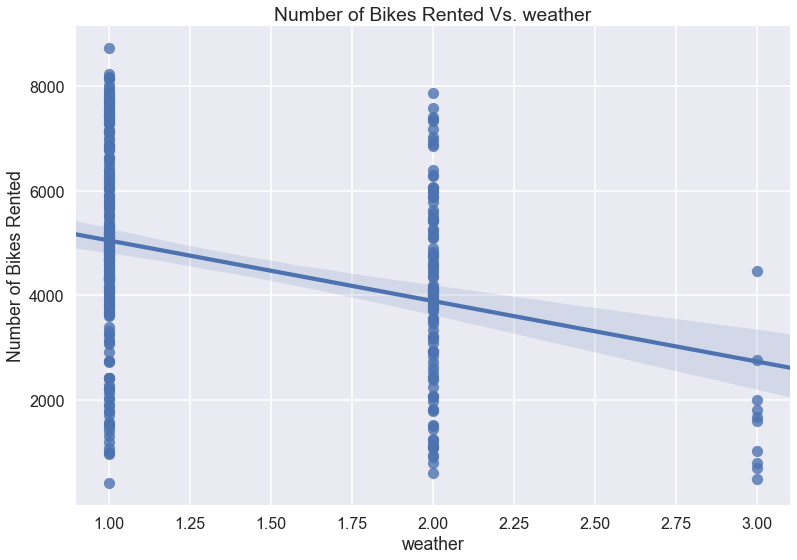

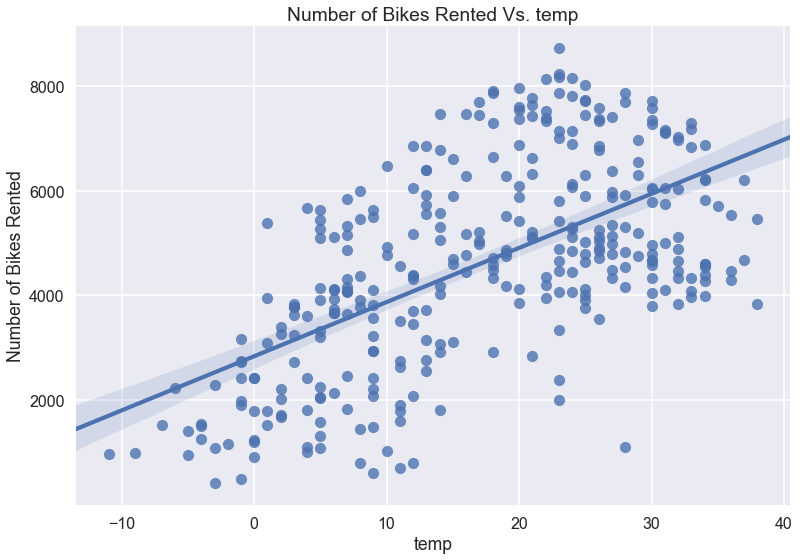

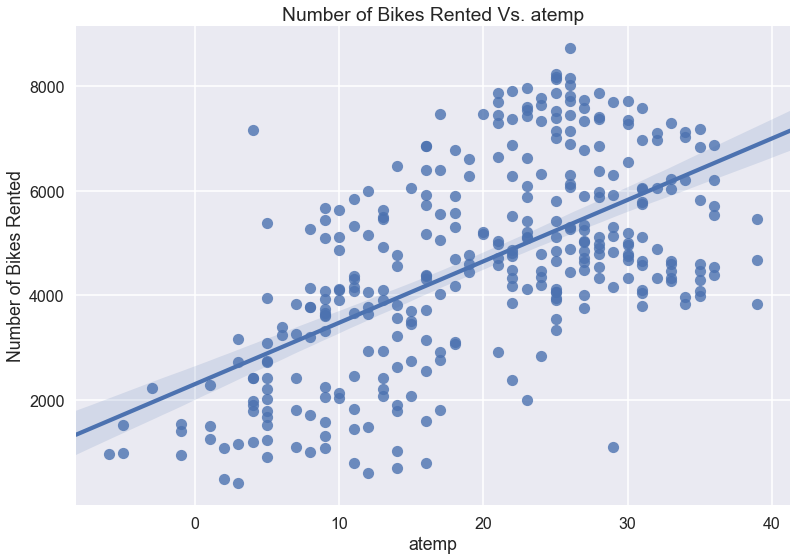

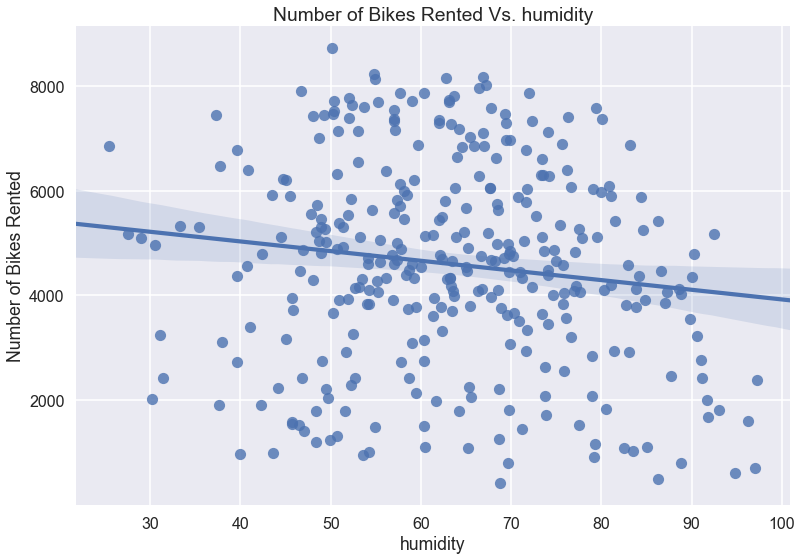

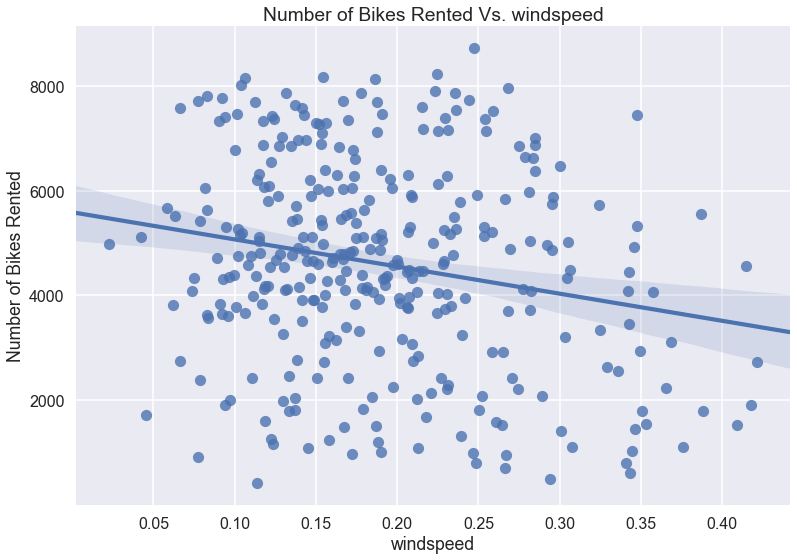

In [16]:
initPredictors = ["season", "month", "holiday", "day_of_week", "workingday", "weather", "temp", "atemp", "humidity", "windspeed"] 

for i, predictor in enumerate(initPredictors):
    fig, ax = plt.subplots()
    ax = sns.regplot(trainDf[predictor], trainDf["count"])
    ax.set_title("Number of Bikes Rented Vs. {}".format(predictor))
    ax.set_xlabel("{}".format(predictor))
    ax.set_ylabel("Number of Bikes Rented")

We observe that `season`, `month`, `temp`, and `atemp` seem to have a non-linear relationship with `number of bikes rented`.
The former is probably best described by a sinusoidal function due to the periodicity of seasons, whereas the latter two would fit a negative quadratic function.

We next require you to pre-process the categorical and numerical attributes in the data set:

- Notice that this data set contains categorical attributes with two or more categories. **Why can't they be directly used as predictors?** Convert these categorical attributes into multiple binary attributes using one-hot encoding: in the place of every categorical attribute $x_j$ that has categories $1, \ldots, K_j$, introduce $K_j-1$ binary predictors $x_{j1}, \ldots, x_{j,K_j-1}$ where $x_{jk}$ is 1 whenever $x_j = k$ and 0 otherwise. 
** Why is it okay to not have a binary column for the $K_j$-th category? **

- Since the attributes are in different scales, it is a good practice to standardize the continuous predictors, i.e. to scale each continuous predictor to have zero mean and a standard deviation of 1. This can be done by applying the following transform to each continuous-valued predictor $j$:
$\hat{x}_{ij} = (x_{ij} - \bar{x}_j) / s_j$, where $\bar{x}_j$ and $s_j$ are the sample mean and sample standard deviation (SD) of predictor $j$ in the training set. We emphasize that the mean and SD values used for standardization must be estimated using only the training set observations, while the transform is applied to both the training and test sets. 
** Why shouldn't we include the test set observations in computing the mean and SD? **

- Provide a table of the summary statistics of the new attributes (`pd.describe()' function will help).

*Hint:* You may use the `pd.get_dummies` function to convert a categorical attribute in a data frame to one-hot encoding. This function creates $K$ binary columns for an attribute with $K$ categories. We suggest that you delete the last (or first) binary column generated by this function.

**Note:** We shall use the term "attribute" to refer to a categorical column in the data set, and the term "predictor" to refer to the individual binary columns resulting out of one-hot encoding.

### Answers to Questions above

* We cannot use categorical variables directly as predictors since non-integer values have no meaning.
* The $K_j$-th category does not need to have a binary column as it is implied as the baseline, i.e. the $0$-vector.
* As a general principle, we do not want to train on the test data. This way, we avoid fitting the training data which would lead to a less general model.

In [17]:
# Create dummy variables
trainBinaryDf = pd.get_dummies(trainDf, columns=["season", "month", "day_of_week", "weather"])
testBinaryDf = pd.get_dummies(testDf, columns=["season", "month", "day_of_week", "weather"])

trainBinaryDf.head()

,Unnamed: 0,holiday,workingday,temp,atemp,humidity,windspeed,count,season_1,season_2,...,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,weather_1,weather_2,weather_3
0,0,0,1,24,26,76.5833,0.118167,6073,0,1,...,0,0,1,0,0,0,0,0,1,0
1,1,0,1,15,19,73.3750,0.174129,6606,0,0,...,0,0,1,0,0,0,0,1,0,0
2,2,0,1,26,28,56.9583,0.253733,7363,0,1,...,0,0,0,0,1,0,0,1,0,0
3,3,0,0,0,4,58.6250,0.169779,2431,0,0,...,1,0,0,0,0,0,0,1,0,0
4,4,0,1,23,23,91.7083,0.097021,1996,0,0,...,0,0,0,1,0,0,0,0,0,1


In [18]:
# Normalize predictors
for column in ["temp", "atemp", "humidity", "windspeed"]:
    colMean = np.mean(trainBinaryDf[column])
    colSD = np.std(trainBinaryDf[column])
    trainBinaryDf[column + "_norm"] = [(x - colMean)/float(colSD) for x in trainBinaryDf[column]]
    testBinaryDf[column + "_norm"] = [(x - colMean)/float(colSD) for x in testBinaryDf[column]]
trainBinaryDf.head()

,Unnamed: 0,holiday,workingday,temp,atemp,humidity,windspeed,count,season_1,season_2,...,day_of_week_4,day_of_week_5,day_of_week_6,weather_1,weather_2,weather_3,temp_norm,atemp_norm,humidity_norm,windspeed_norm
0,0,0,1,24,26,76.5833,0.118167,6073,0,1,...,0,0,0,0,1,0,0.624743,0.651090,0.922058,-0.930164
1,1,0,1,15,19,73.3750,0.174129,6606,0,0,...,0,0,0,1,0,0,-0.180583,-0.054841,0.697907,-0.213825
2,2,0,1,26,28,56.9583,0.253733,7363,0,1,...,1,0,0,1,0,0,0.803704,0.852785,-0.449062,0.805143
3,3,0,0,0,4,58.6250,0.169779,2431,0,0,...,0,0,0,1,0,0,-1.522794,-1.567551,-0.332616,-0.269507
4,4,0,1,23,23,91.7083,0.097021,1996,0,0,...,0,0,0,0,0,1,0.535262,0.348548,1.978781,-1.200843


In [19]:
trainBinaryDf.describe()

,Unnamed: 0,holiday,workingday,temp,atemp,humidity,windspeed,count,season_1,season_2,...,day_of_week_4,day_of_week_5,day_of_week_6,weather_1,weather_2,weather_3,temp_norm,atemp_norm,humidity_norm,windspeed_norm
count,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,...,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,3.310000e+02,3.310000e+02,3.310000e+02,3.310000e+02
mean,165.000000,0.033233,0.670695,17.018127,19.543807,63.385776,0.190833,4598.447130,0.217523,0.259819,...,0.123867,0.145015,0.135952,0.640483,0.329305,0.030211,-3.823729e-17,-1.214202e-16,-8.439037e-16,1.549616e-15
std,95.695698,0.179515,0.470672,11.192515,9.930991,14.334789,0.078240,1935.319338,0.413186,0.439199,...,0.329929,0.352649,0.343256,0.480585,0.470672,0.171428,1.001514e+00,1.001514e+00,1.001514e+00,1.001514e+00
min,0.000000,0.000000,0.000000,-11.000000,-6.000000,25.416700,0.022392,431.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-2.507081e+00,-2.576025e+00,-2.652747e+00,-2.156128e+00
25%,82.500000,0.000000,0.000000,7.500000,11.000000,52.702900,0.133083,3370.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-8.516886e-01,-8.616201e-01,-7.463695e-01,-7.392325e-01
50%,165.000000,0.000000,1.000000,18.000000,21.000000,63.291700,0.178479,4648.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,8.785869e-02,1.468532e-01,-6.572679e-03,-1.581428e-01
75%,247.500000,0.000000,1.000000,26.000000,27.000000,73.500000,0.235380,5981.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,8.037042e-01,7.519372e-01,7.066402e-01,5.702098e-01
max,330.000000,1.000000,1.000000,38.000000,39.000000,97.250000,0.421642,8714.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.877473e+00,1.962105e+00,2.365957e+00,2.954455e+00


In [20]:
# Drop k-th dummies
predictors = ["holiday", "workingday", "temp_norm","atemp_norm","humidity_norm","windspeed_norm",
              "weather_1", "weather_2", "day_of_week_0", "day_of_week_1", "day_of_week_2",
              "day_of_week_3", "day_of_week_4", "day_of_week_5", "season_1",
              "season_2", "season_3", "month_1", "month_2", "month_3", "month_4", "month_5",
              "month_6", "month_7", "month_8", "month_9", "month_10", "month_11", "const"]

# Add a constant term to our predictors
trainBinaryDf = sm.add_constant(trainBinaryDf)
testBinaryDf = sm.add_constant(testBinaryDf)

trainPredict = trainBinaryDf[predictors]
testPredict = testBinaryDf[predictors]

## Part (b): Multiple Linear Regression

We are now ready to fit a linear regression model and analyze its coefficients and residuals.

- Fit a multiple linear regression model to the training set, and report its $R^2$ score on the test set.
- *Statistical significance*: Using a t-test, find out which of estimated coefficients are statistically significant at a significance level of 5% (p-value<0.05). Based on the results of the test, answer the following questions:
    - Which among the predictors have a positive correlation with the number of bike rentals? 
    - Does the day of a week have a relationship with bike rentals? 
    - Does the month influence the bike rentals? 
    - What effect does a holiday have on  bike rentals? 
    - Is there a difference in the coefficients assigned to `temp` and `atemp`? Give an explanation for your observation.
- *Residual plot:* Make a plot of residuals of the fitted model ${e} = y - \hat{y}$ as a function of the predicted value $\hat{y}$. Note that this is different from the residual plot for simple linear regression. Draw a horizontal line denoting the zero residual value on the Y-axis. Does the plot reveal a non-linear relationship between the predictors and response? What does the plot convey about the variance of the error terms?


In [21]:
# Fit OLS multilinear regression on test set
X = trainPredict
Y = trainDf["count"]

allKModel = sm.OLS(Y, X).fit()
predictions = allKModel.predict(X)
allKModel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       0.576
Model:                            OLS   Adj. R-squared:                  0.538
Method:                 Least Squares   F-statistic:                     15.25
Date:                Wed, 04 Oct 2017   Prob (F-statistic):           6.56e-42
Time:                        18:25:59   Log-Likelihood:                -2832.1
No. Observations:                 331   AIC:                             5720.
Df Residuals:                     303   BIC:                             5827.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
holiday         -616.6027    405.068     -1.522      0.129   -1413.706     180.500
workingday       -24.0933    174.143     -0.138      0.890    -366.777     318.590
temp_norm        924.3344    473.819      1.951      0.052      -8.058    1856.727
atemp_norm       311.9618    429.337      0.727      0.468    -532.898    1156.822
humidity_norm   -547.6638    113.029     -4.845      0.000    -770.085    -325.243
windspeed_norm  -254.7369     80.644     -3.159      0.002    -413.431     -96.043
weather_1       1581.9783    529.223      2.989      0.003     540.560    2623.396
weather_2       1565.4117    478.500      3.271      0.001     623.807    2507.016
day_of_week_0   -465.1450    269.154     -1.728      0.085    -994.794      64.504
day_of_week_1   -256.6501    172.675     -1.486      0.138    -596.445      83.145
day_of_week_2   -328.1845    204.810     -1.602      0.110    -731.214      74.845
day_of_week_3     37.6128    214.916      0.175      0.861    -385.304     460.530
day_of_week_4    -71.6425    208.337     -0.344      0.731    -481.612     338.327
day_of_week_5    -21.8317    200.742     -0.109      0.913    -416.858     373.194
season_1       -1226.1865    506.763     -2.420      0.016   -2223.407    -228.966
season_2        -327.3575    573.373     -0.571      0.568   -1455.654     800.939
season_3        -193.3050    449.171     -0.430      0.667   -1077.194     690.584
month_1          118.8358    505.353      0.235      0.814    -875.611    1113.282
month_2          207.7759    516.216      0.402      0.688    -808.047    1223.599
month_3          358.0167    511.391      0.700      0.484    -648.310    1364.344
month_4          452.1849    657.792      0.687      0.492    -842.234    1746.604
month_5           53.0233    700.991      0.076      0.940   -1326.403    1432.450
month_6         -673.4271    696.142     -0.967      0.334   -2043.313     696.458
month_7        -1161.1512    701.261     -1.656      0.099   -2541.109     218.806
month_8         -657.6397    684.628     -0.961      0.338   -2004.868     689.588
month_9          523.9804    548.284      0.956      0.340    -554.945    1602.906
month_10         605.0867    439.844      1.376      0.170    -260.449    1470.623
month_11         231.5175    413.966      0.559      0.576    -583.094    1046.129
const           3672.2940    664.433      5.527      0.000    2364.807    4979.781
==============================================================================
Omnibus:                       28.947   Durbin-Watson:                   1.912
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                9.753
Skew:                           0.054   Prob(JB):                      0.00762
Kurtosis:                       2.166   Cond. No.                     1.05e+16
================================

### Assesment of The Regression Model Above
- The following predictors have a statistically significant correlation with the number of bike rentals:
    * `weather_1`, `weather_2`, `humidity_norm`, `windspeed_norm`
    * `month_4` April, `month_9` September, `month_10` October, `month_11` November, `season_1` Spring
    * `const`
- We determined these statistically significant predictors by looking at the P>|t| values above.  If the value is less than .05, then that predictor's coefficient is significant.  
- The day of a week does not have a statistically significant relationship with bike rentals.
- The month certainly influences the number of bike rentals (as evidenced by the significant predictors above)
- Ceteris paribus, a holiday does not have a significant relationship with bike rentals.
- There is no statistical significant  difference in the coefficients assigned to `temp` and `atemp`, as both 95%-CIs have similar bounds, including 0.  However, `temp` is almost significant, while `atemp` is nowhere close to being significant.  This difference is surprising, but might be explained by the fact that apparent temperatures can vary significantly depending on other weather factors, while temperature is a baseline measure.  

In [22]:
testY = testDf["count"]
testYHat = allKModel.predict(testPredict)
print("Test R-Squared: {}".format(r2_score(testY, testYHat)))

Test R-Squared: 0.24934211146527574


## Low $R^2$ Value Interpretation
The comparatively low $R^2$ value indicates that our model is overfitting the training data, especially given the larger $R^2$ value for the training data.

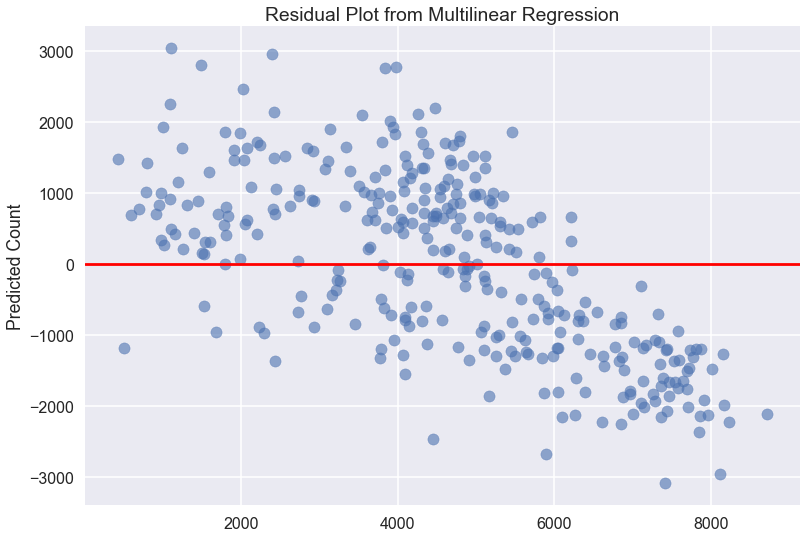

In [23]:
residuals = list(map(lambda yhat, y: yhat - y, predictions, Y)) #YNorm instead of Y
fig, ax = plt.subplots()

ax.scatter(Y, residuals, alpha=.6)
ax.set_title("Residual Plot from Multilinear Regression")
ax.axhline(y=0, color="r")
# ax.set_xlabel("Normalized True Count") True?
ax.set_ylabel("Predicted Count")

### Residuals analysis
The plot reveals a non-linear relationship between the predictors and response, since the error terms are not evenly distributed around the mean, and their variance depends on y, decreasing as y grows. This violates our regression assumption of normal, homoskedastic noise.

## Part (c): Checking Collinearity

Does the data suffer from multi-collinearity? To answer this question, let us first analyze the correlation matrix for the data. Compute the (Pearson product-moment) correlation matrix for the predictor variables in the training set, and visualize the matrix using a heatmap. For categorical attributes, you should use each binary predictor resulting from one-hot encoding to compute their correlations.  Are there predictors that fall into natural groups based on the correlation values? 

*Hint:* You may use the `np.corrcoef` function to compute the correlation matrix for a data set (do not forget to transpose the data matrix). You may use `plt.pcolor` function to visualize the correlation matrix.

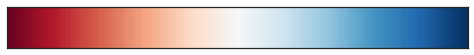

In [24]:
dpal = sns.choose_colorbrewer_palette('diverging', as_cmap=True)

/Applications/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  """Entry point for launching an IPython kernel.


([<matplotlib.axis.YTick at 0x11ccc7748>,
 <a list of 28 Text yticklabel objects>)

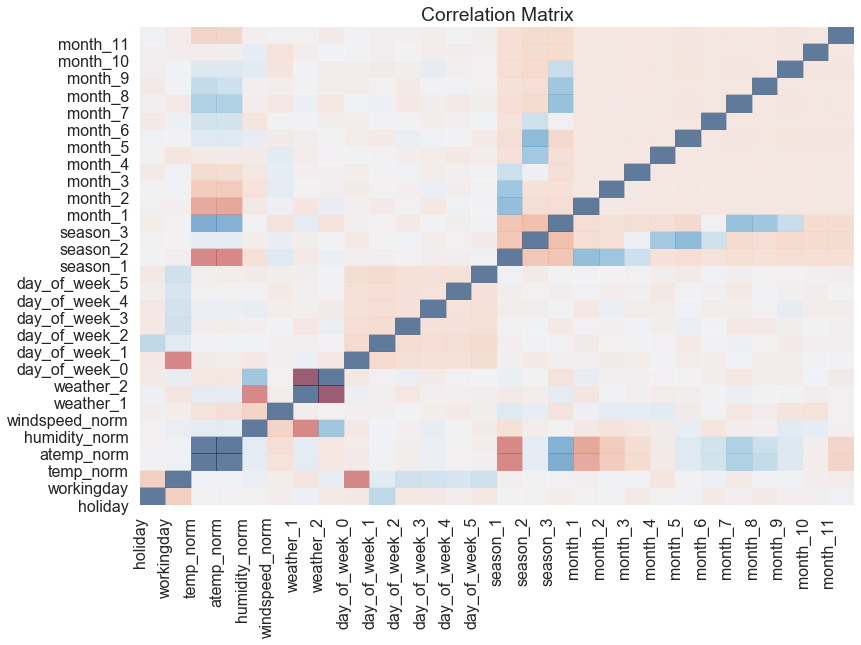

In [25]:
plt.pcolor(X.ix[:, X.columns != "const"].corr(), cmap=dpal, alpha=.6)
ax = plt.gca()
ax.set_title("Correlation Matrix")
labels = predictors[:-1]
plt.xticks(range(len(labels)), labels, rotation=90)
plt.yticks(range(len(labels)), labels)

We observe the following relationships:
* `temp_norm` and `atemp_norm` are unsurprisingly very much positively correlated.
* `weather_1` and `weather_2` are negatively correlated, which makes sense since they derive from categorical data.
* We can see "boxes" for `day_of_week_j` and `month_k` which is intuitive.
* `temp_norm` and `atemp_norm` are correlated with the months.
* Naturally, the seasons are correlated with the months.
Note that we excluded the constant term from our correlation matrix, as the variance of a constant is 0, so calculating the correlation of a variable with a constant would yield an undefined value. 

## Part (d): Subset Selection

Apply either one of the following subset selection methods discussed in class to choose a minimal subset of predictors that are related to the response variable:
- Step-wise forward selection
- Step-wise backward selection

We require you to implement both these methods *from scratch*. You may use the Bayesian Information Criterion (BIC) to choose the subset size in each method. Do these methods eliminate one or more of the redundant predictors (if any) identified in Part (c)? In each case, fit linear regression models using the identified subset of predictors to the training set. How do the test $R^2$ scores for the fitted models compare with the model fitted in Part (b) using all predictors?




In [26]:
# Implement step-wise forward selection

# The set of predictors
predictors = ["const", "holiday", "workingday", "temp_norm", "atemp_norm", "humidity_norm", "windspeed_norm",
              "weather_1", "weather_2", "day_of_week_0", "day_of_week_1", "day_of_week_2",
              "day_of_week_3", "day_of_week_4", "day_of_week_5", "season_1",
              "season_2", "season_3", "month_1", "month_2", "month_3", "month_4", "month_5",
              "month_6", "month_7", "month_8", "month_9", "month_10", "month_11"]


forwardPredictors = []
forwardModels = []

for _ in range(len(predictors)):   
    
    betterModel, betterPredictor, betterBIC = None, None, sys.maxsize
    
    for addedPredictor in predictors:
        X = trainBinaryDf[forwardPredictors + [addedPredictor]]
        newModel = sm.OLS(Y, X).fit()
        
        bestBIC = min([model.bic for model in forwardModels] + [betterBIC])
        if newModel.bic < bestBIC:
            betterModel = newModel
            betterPredictor = addedPredictor
            betterBIC = newModel.bic

    if betterModel:
        forwardModels.append(betterModel)
        forwardPredictors.append(betterPredictor)
    else:
        break

forwardBICs = [model.bic for model in forwardModels]
forwardRSquareds = [model.rsquared for model in forwardModels]
print("Predictors: {}".format(forwardPredictors))
print("Rsquareds: {}".format(forwardRSquareds))
print("BICs: {}".format(forwardBICs))

Predictors: ['const', 'atemp_norm', 'humidity_norm', 'season_1', 'month_9', 'month_10', 'windspeed_norm', 'month_7']
Rsquareds: [0.0, 0.36094811139379512, 0.41237745384733182, 0.46809945208979198, 0.48910179719539404, 0.5104124449264057, 0.5237587713442825, 0.53432886723575779]
BICs: [5954.1722009863015, 5811.7625734619323, 5789.7935136501037, 5762.6186708109581, 5755.0860658498423, 5746.7852518967693, 5743.438926291893, 5741.8118001623388]


## Results
The step-wise forward regression yields a 6-parameter model. `temp_norm` and some `season`/`month` redundancies (by collinearity) have been resolved.  We correctly see that the BIC of each iteration of this algorithm decreases, signifying an improvement overall in our model.  Further, our $R^2$ values increase to just below the original model with all predictors.  This is encouraging, since our new model is significantly smaller but about as powerful as the first model.

## Testing

In [27]:
testY = testDf["count"]
testPredict = testBinaryDf[forwardPredictors]
testYHat = forwardModels[-1].predict(testPredict)
print("Test R-Squared: {}".format(r2_score(testY, testYHat)))

Test R-Squared: 0.23390728606336764


Testing the resulting model on the test dataset yields a slightly lower $R^2$ value than the one in Part (b).

In [28]:
# Implement step-wise backward selection

# The set of predictors
predictors = set(["const", "holiday", "workingday", "temp_norm", "atemp_norm", "humidity_norm", "windspeed_norm",
                  "weather_1", "weather_2", "day_of_week_0", "day_of_week_1", "day_of_week_2",
                  "day_of_week_3", "day_of_week_4", "day_of_week_5", "season_1",
                  "season_2", "season_3", "month_1", "month_2", "month_3", "month_4", "month_5",
                  "month_6", "month_7", "month_8", "month_9", "month_10", "month_11"])


backwardPredictors = set(predictors)
backwardModels = []

for _ in range(len(predictors)):   
    
    betterModel, betterPredictor, betterBIC = None, None, sys.maxsize
    
    for removedPredictor in backwardPredictors:
        X = trainBinaryDf[list(backwardPredictors - set([removedPredictor]))]
        newModel = sm.OLS(Y, X).fit()
        
        bestBIC = min([model.bic for model in backwardModels] + [betterBIC])
        if newModel.bic < bestBIC:
            betterModel = newModel
            betterPredictor = removedPredictor
            betterBIC = newModel.bic

    if betterModel:
        backwardModels.append(betterModel)
        backwardPredictors.remove(betterPredictor)
    else:
        break

backwardBICs = [model.bic for model in backwardModels]
backwardRSquareds = [model.rsquared for model in backwardModels]
print("Predictors: {}".format(backwardPredictors))
print("Rsquareds: {}".format(backwardRSquareds))
print("BICs: {}".format(backwardBICs))

Predictors: {'const', 'month_6', 'weather_2', 'day_of_week_1', 'windspeed_norm', 'day_of_week_4', 'month_8', 'humidity_norm', 'temp_norm', 'holiday', 'day_of_week_5', 'workingday', 'month_7', 'day_of_week_2', 'season_1', 'weather_1', 'day_of_week_3'}
Rsquareds: [0.57612017442132424, 0.57605080910137474, 0.57588543174157469, 0.5756513106142167, 0.57513980584466751, 0.57432856240861385, 0.57347456671855168, 0.57236259109017618, 0.57102272820283972, 0.56788327070409095, 0.56358808011277584, 0.5584752558959003]
BICs: [5820.9282263781215, 5815.1802696804134, 5809.507245152513, 5803.8877960781911, 5798.484420821208, 5793.3137231919627, 5788.175002389833, 5783.2346965933684, 5778.4680378881812, 5775.0795120710272, 5772.5512515638839, 5770.6044544609886]


### Results of Backwards Selection

Here, we recognize several problems with the result of this backwards selection.  First, the number of predictors in this model is still very large, and there are still many predictors that are colinear with one another.  Secondly, the $R^2$ values are decreasing, as well as our BIC values, which means that while our scoring metric (BIC) improves, we lose explanatory power of the data as well.  

### Testing

In [29]:
testY = testDf["count"]
testPredict = testBinaryDf[list(backwardPredictors)]
testYHat = backwardModels[-1].predict(testPredict)
print("Test R-Squared: {}".format(r2_score(testY, testYHat)))

Test R-Squared: 0.2560628878069243


Testing the resulting model on the test dataset yields a marginally higher $R^2$ value than the one in Part (b).

## Part (e): Cross Validation

- Perform a 10-fold cross-validation procedure to select between the 3 competing models you have so far: the model with the best BIC from Step-wise forward selection, the model with the best BIC from Step-wise backward selection (if it is different), and the model with all possible predictors.  Report the average $R^2$ across all 10 validation sets for each model and compare the results.  Why do you think this is the case?
- Evaluate each of the 3 models on the provided left out test set by calculating $R^2$.  Do the results agree with the cross-validation?  Why or why not?

In [30]:
forwardModel = forwardModels[-1]
backwardModel = backwardModels[-1]

kf = KFold(n_splits=10)
X = trainPredict
Y = trainDf["count"]

allKRSquares = []
forwardRSquares = []
backwardRSquares = []

for trainIndices, validationIndices in kf.split(X):
    trainX = X.iloc[trainIndices]
    trainY = Y.iloc[trainIndices]
    
    validationX = X.iloc[validationIndices]
    validationY = Y.iloc[validationIndices]

    allKX = trainX
    allK = sm.OLS(trainY, allKX).fit()

    forwardX = trainX[list(forwardPredictors)]
    forward = sm.OLS(trainY, forwardX).fit()
        
    backwardX = trainX[list(backwardPredictors)]
    backward = sm.OLS(trainY, backwardX).fit()
        
    allKYHat = allK.predict(validationX)
    forwardYHat = forward.predict(validationX[list(forwardPredictors)])
    backwardYHat = backward.predict(validationX[list(backwardPredictors)])
    
    allKRSquares.append(r2_score(validationY, allKYHat))
    forwardRSquares.append(r2_score(validationY, forwardYHat))
    backwardRSquares.append(r2_score(validationY, backwardYHat))
    
print("Original model mean: {}, Forward model mean: {}, Backwards model mean: {}.".format(np.mean(allKRSquares), np.mean(forwardRSquares), np.mean(backwardRSquares)))
      

Original model mean: 0.34257855093958417, Forward model mean: 0.44036505151424993, Backwards model mean: 0.44992159742375665.


### Summary of 10-fold cross-validation
We see that our average $R^2$ score for 10-fold cross-validation from our original model was just .34, which is significantly smaller than both the forward and backwards models.  This is likely due to the overfitting of our original model with the training dataset that it is given for each data split.  As we have seen earlier, our backward step model actually scored the best on our test data our of any other model.  This is surprising for numerous reasons, but mostly because there still are a large amount of parameters in that model that might indicate overfitting.  